# Introduction

This project is to dig through the data of NYC Taxi rides for findings on medical trends in NYC. We will focus on rides that relate to a hospital by its coordinates or area of operation. The project consists of two parts:

1. EDA Analysis and Constructing Goal Metrics
2. RNN prediction of future trend with LSTM

The data also has two parts with different data sources:

1. 2009 to 2015, 'New York City Taxi Fare Prediction', Kaggle
2. 2017 to 2019, Taxi & Limousine Commission Trip Record Data

The two datasets are very different in terms of its given features and source. One with exact coordinates but lack other information, the other with only vague area code but with many other features, both numerical and categorical ones, to work with. The idea of including both datasets is to try distinct approaches to achieving our goal, which is to look for possible trends of going to hospitals using taxi rides.

## 1. 2009 to 2015, 'New York City Taxi Fare Prediction', Kaggle

In [2]:
import pandas as pd
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import choice
from datetime import datetime
from PIL import Image

C:\Users\Haipeng Pan\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### 1.1 Data Importing, Data Manipulation & Feature Engineering

The dataset originally has 7 features and 55M observations

In [2]:
# load the data from 2009 - 2015
# https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/data

# fare_pred = pd.read_csv('fare_prediction_2009_2015_test.csv')
fare_pred = pd.read_csv('fare_prediction_2009_2015_train.csv')

In [15]:
#fare_pred.to_csv('fare_pred.csv')
fare_pred.to_csv('fare_prediction_2009_2015_train.csv')

In [8]:
# restrict area, and get rid of outliers
fare_pred = fare_pred[(fare_pred.pickup_latitude >= 40.5) 
        & (fare_pred.pickup_latitude <= 40.9) 
        & (fare_pred.pickup_longitude >= -74.3) 
        & (fare_pred.pickup_longitude <= -73.7) 
        & (fare_pred.dropoff_latitude >= 40.5) 
        & (fare_pred.dropoff_latitude <= 40.9) 
        & (fare_pred.dropoff_longitude >= -74.3) 
        & (fare_pred.dropoff_longitude <= -73.7)
        & (fare_pred.passenger_count <= 10)]

fare_pred = fare_pred.reset_index(drop=True)

In [3]:
fare_pred = fare_pred.drop(columns = 'Unnamed: 0', axis = 1)

In [7]:
# construct time related features
time = pd.DatetimeIndex(fare_pred['pickup_datetime'])

fare_pred['year'] = time.year
fare_pred['month'] = time.month
fare_pred['day'] = time.day
fare_pred['hour'] = time.hour

In [4]:
fare_pred

fare_amount          pickup_datetime  pickup_longitude  \
0                 4.5  2009-06-15 17:26:21 UTC        -73.844311   
1                16.9  2010-01-05 16:52:16 UTC        -74.016048   
2                 5.7  2011-08-18 00:35:00 UTC        -73.982738   
3                 7.7  2012-04-21 04:30:42 UTC        -73.987130   
4                 5.3  2010-03-09 07:51:00 UTC        -73.968095   
...               ...                      ...               ...   
54175641         14.0  2014-03-15 03:28:00 UTC        -74.005272   
54175642          4.2  2009-03-24 20:46:20 UTC        -73.957784   
54175643         14.1  2011-04-02 22:04:24 UTC        -73.970505   
54175644         28.9  2011-10-26 05:57:51 UTC        -73.980901   
54175645          7.5  2014-12-12 11:33:00 UTC        -73.969722   

          pickup_latitude  dropoff_longitude  dropoff_latitude  \
0               40.721319         -73.841610         40.712278   
1               40.711303         -73.979268         40.782004   
2               40.761270         -73.991242         40.750562   
3               40.733143         -73.991567         40.758092   
4               40.768008         -73.956655         40.783762   
...                   ...                ...               ...   
54175641        40.740027         -73.963280         40.762555   
54175642        40.765530         -73.951640         40.773959   
54175643        40.752325         -73.960537         40.797342   
54175644        40.764629         -73.870605         40.773963   
54175645        40.797668         -73.970885         40.783313   

          passenger_count  year  month  day  hour  hospital  
0                       1  2009      6   15    17         0  
1                       1  2010      1    5    16         0  
2                       2  2011      8   18     0         0  
3                       1  2012      4   21     4         0  
4                       1  2010      3    9     7         0  
...                   ...   ...    ...  ...   ...       ...  
54175641                1  2014      3   15     3         0  
54175642                1  2009      3   24    20         0  
54175643                1  2011      4    2    22         0  
54175644                1  2011     10   26     5         0  
54175645                1  2014     12   12    11         0  

[54175646 rows x 12 columns]

In [7]:
fare_pred.describe()

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  5.417565e+07      5.417565e+07     5.417565e+07       5.417565e+07   
mean   1.128028e+01     -7.397552e+01     4.075085e+01      -7.397467e+01   
std    2.073682e+01      3.446054e-02     2.687005e-02       3.384974e-02   
min   -3.000000e+02     -7.430000e+01     4.050000e+01      -7.430000e+01   
25%    6.000000e+00     -7.399228e+01     4.073658e+01      -7.399159e+01   
50%    8.500000e+00     -7.398210e+01     4.075336e+01      -7.398062e+01   
75%    1.250000e+01     -7.396835e+01     4.076752e+01      -7.396544e+01   
max    9.396336e+04     -7.370000e+01     4.090000e+01      -7.370000e+01   

       dropoff_latitude  passenger_count          year         month  \
count      5.417565e+07     5.417565e+07  5.417565e+07  5.417565e+07   
mean       4.075117e+01     1.685454e+00  2.011738e+03  6.267746e+00   
std        3.063432e-02     1.315415e+00  1.862607e+00  3.436931e+00   
min        4.050000e+01     0.000000e+00  2.009000e+03  1.000000e+00   
25%        4.073558e+01     1.000000e+00  2.010000e+03  3.000000e+00   
50%        4.075384e+01     1.000000e+00  2.012000e+03  6.000000e+00   
75%        4.076837e+01     2.000000e+00  2.013000e+03  9.000000e+00   
max        4.090000e+01     2.080000e+02  2.015000e+03  1.200000e+01   

                day          hour      hospital  
count  5.417565e+07  5.417565e+07  5.417565e+07  
mean   1.571212e+01  1.351071e+01  1.785210e-02  
std    8.685318e+00  6.515277e+00  1.324138e-01  
min    1.000000e+00  0.000000e+00  0.000000e+00  
25%    8.000000e+00  9.000000e+00  0.000000e+00  
50%    1.600000e+01  1.400000e+01  0.000000e+00  
75%    2.300000e+01  1.900000e+01  0.000000e+00  
max    3.100000e+01  2.300000e+01  1.000000e+00

In [8]:
fare_pred.isnull().any()

fare_amount          False
pickup_datetime      False
pickup_longitude     False
pickup_latitude      False
dropoff_longitude    False
dropoff_latitude     False
passenger_count      False
year                 False
month                False
day                  False
hour                 False
hospital             False
dtype: bool

### 1.2 Exploratory Data Analysis

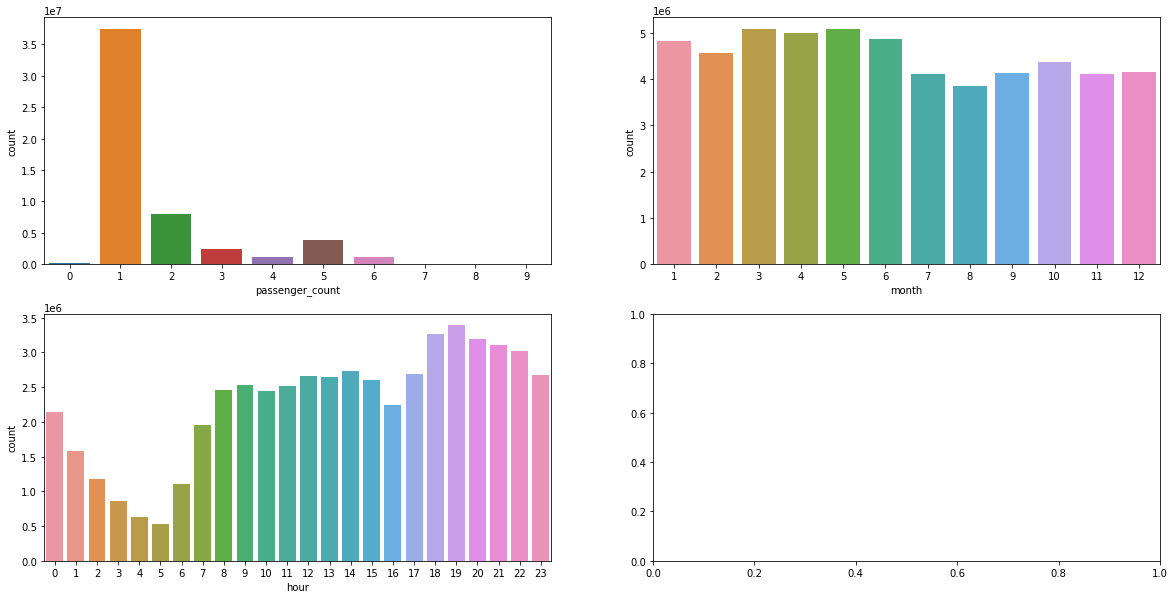

In [15]:
# plot by different features
_,axss = plt.subplots(2,2, figsize=[20,10])

sns.countplot(x="passenger_count", data=fare_pred, ax=axss[0][0])
sns.countplot(x="month", data=fare_pred, ax=axss[0][1])
sns.countplot(x="hour", data=fare_pred, ax=axss[1][0])

### 1.3 Goal Metric Setup

In this section, we want to determine where the hospitals are at, and then we are able to filter out those trips that are possibly heading toward a hospital. If a ride ends right next to a hospital, we classify it as hospital-related.

Hospital coordinates are easy to find with its latitude and longitude on Google Maps, we will simply 

1. Circle up a hospital with its surrounding streets and record the coordinates, and
2. Add each 'circle' to the filter list, and
3. Build a boolean feature 'near_hospital'

We get a map of target hospitals in NYC after the search, as marked by the stars.

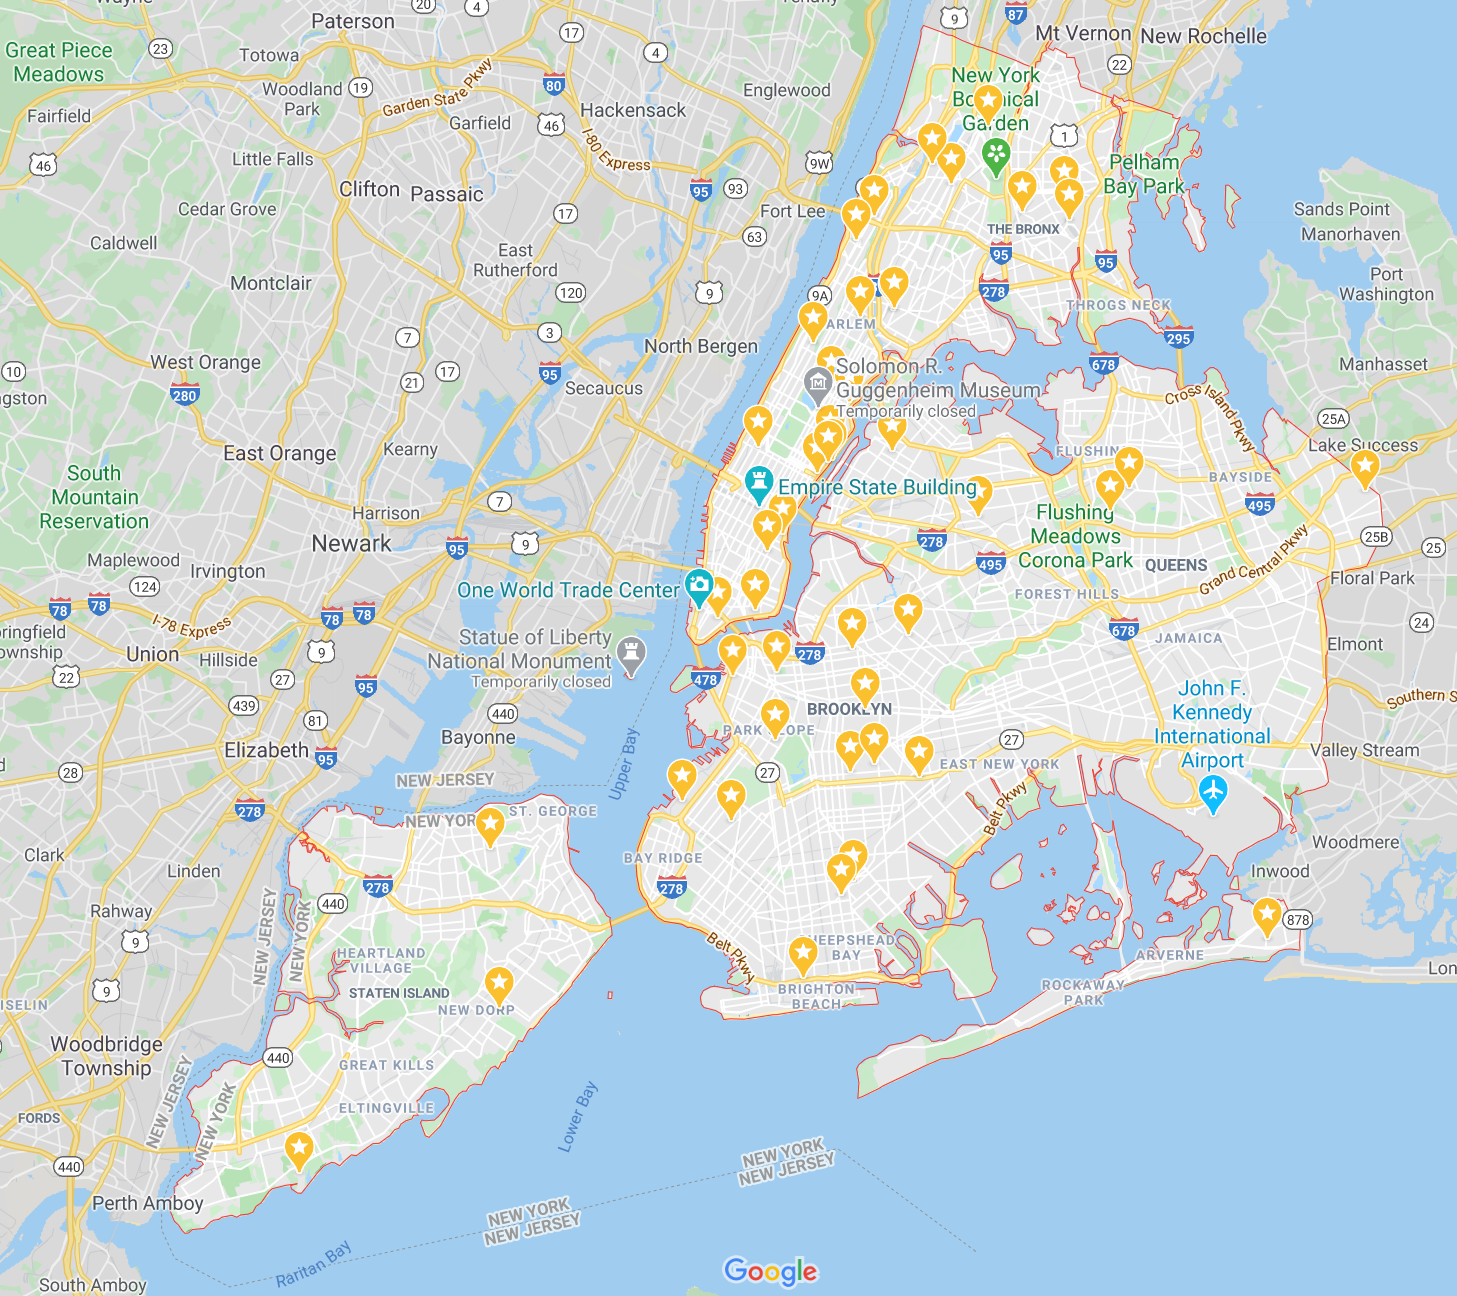

In [5]:
Image.open('hospital2.png')

In [14]:
# construct hospital zones
import time
def near_hospital(lat,long):
    res = []
    for i in range(len(lat)):
        if ((40.709674 <= lat[i] <= 40.711000 and -74.005608 <= long[i] <= -74.004272)
            or (40.712821 <= lat[i] <= 40.713601 and -73.988595 <= long[i] <= -73.986959)
            or (40.732665 <= lat[i] <= 40.733909 and -73.983183 <= long[i] <= -73.981172)
            or (40.735981 <= lat[i] <= 40.743803 and -73.978520 <= long[i] <= -73.972119)
            or (40.768609 <= lat[i] <= 40.770421 and -73.988108 <= long[i] <= -73.984739)
            or (40.763564 <= lat[i] <= 40.765556 and -73.955626 <= long[i] <= -73.952169)
            or (40.773008 <= lat[i] <= 40.774282 and -73.961858 <= long[i] <= -73.959850)
            or (40.783655 <= lat[i] <= 40.786194 and -73.946637 <= long[i] <= -73.942002)
            or (40.787917 <= lat[i] <= 40.792360 and -73.954797 <= long[i] <= -73.950932)
            or (40.804004 <= lat[i] <= 40.806150 and -73.962477 <= long[i] <= -73.959840)
            or (40.812759 <= lat[i] <= 40.815398 and -73.940791 <= long[i] <= -73.936695)
            or (40.838570 <= lat[i] <= 40.844186 and -73.945534 <= long[i] <= -73.938377)
            or (40.848762 <= lat[i] <= 40.849894 and -73.933723 <= long[i] <= -73.931931)
            or (40.815436 <= lat[i] <= 40.817973 and -73.926213 <= long[i] <= -73.922800)
            or (40.865298 <= lat[i] <= 40.869227 and -73.907819 <= long[i] <= -73.902368)
            or (40.860091 <= lat[i] <= 40.861301 and -73.898101 <= long[i] <= -73.896914)
            or (40.878955 <= lat[i] <= 40.882221 and -73.881770 <= long[i] <= -73.878455)
            or (40.850318 <= lat[i] <= 40.851030 and -73.865906 <= long[i] <= -73.865203)
            or (40.853474 <= lat[i] <= 40.857477 and -73.850141 <= long[i] <= -73.843795)
            or (40.844299 <= lat[i] <= 40.850825 and -73.846770 <= long[i] <= -73.836788)
            or (40.689431 <= lat[i] <= 40.690521 and -73.998400 <= long[i] <= -73.996539)
            or (40.691926 <= lat[i] <= 40.689823 and -73.978941 <= long[i] <= -73.977066)
            or (40.666977 <= lat[i] <= 40.668727 and -73.980556 <= long[i] <= -73.977710)
            or (40.645700 <= lat[i] <= 40.647174 and -74.021635 <= long[i] <= -74.019819)
            or (40.638441 <= lat[i] <= 40.640640 and -74.000448 <= long[i] <= -73.996215)
            or (40.617368 <= lat[i] <= 40.619243 and -73.943645 <= long[i] <= -73.942543)
            or (40.613230 <= lat[i] <= 40.614199 and -73.949312 <= long[i] <= -73.947720)
            or (40.586928 <= lat[i] <= 40.584598 and -73.966344 <= long[i] <= -73.963426)
            or (40.597688 <= lat[i] <= 40.599512 and -73.754230 <= long[i] <= -73.752497)
            or (40.698223 <= lat[i] <= 40.700730 and -73.944381 <= long[i] <= -73.941151)
            or (40.703417 <= lat[i] <= 40.704990 and -73.918505 <= long[i] <= -73.916590)
            or (40.677826 <= lat[i] <= 40.679019 and -73.938155 <= long[i] <= -73.936534)
            or (40.654342 <= lat[i] <= 40.657779 and -73.947365 <= long[i] <= -73.939619)
            or (40.658139 <= lat[i] <= 40.660536 and -73.934004 <= long[i] <= -73.932339)
            or (40.654295 <= lat[i] <= 40.656782 and -73.914662 <= long[i] <= -73.910744)
            or (40.767454 <= lat[i] <= 40.768624 and -73.925420 <= long[i] <= -73.924074)
            or (40.744006 <= lat[i] <= 40.745930 and -73.888384 <= long[i] <= -73.883817)
            or (40.746119 <= lat[i] <= 40.748321 and -73.825993 <= long[i] <= -73.824363)
            or (40.754722 <= lat[i] <= 40.756624 and -73.818312 <= long[i] <= -73.815638)
            or (40.749473 <= lat[i] <= 40.756425 and -73.713683 <= long[i] <= -73.704220)
            or (40.772252 <= lat[i] <= 40.779303 and -73.703020 <= long[i] <= -73.698846)):
            res.append(1)
        else:
            res.append(0)
    return res

start = time.time()
fare_pred['hospital'] = near_hospital(fare_pred['dropoff_latitude'], fare_pred['dropoff_longitude'])
print('Time used', time.time() - start, 's')

In [16]:
# total number of rides classified as hospital-related
sum(fare_pred['hospital'])

967149

In [24]:
# build the dataframe of percentage of rides with respect to year and month
temp = fare_pred.groupby(['year','month'])['hospital'].sum() / fare_pred.groupby(['year','month'])['hospital'].count()

In [20]:
temp1 = fare_pred.groupby(['year','month','day'])['hospital'].sum()

In [21]:
pd.DataFrame(temp1)

hospital
year month day          
2009 1     1         259
           2         355
           3         299
           4         267
           5         400
...                  ...
2015 6     26        413
           27        327
           28        269
           29        360
           30        377

[2372 rows x 1 columns]

In [22]:
temp.to_csv('temp_2009.csv')

We have generated the desired data from 2009 to 2015 for further use.

## 2. 2017 to 2019, Taxi & Limousine Commission Trip Record Data

### 2.1 Data Importing, Data Manipulation & Feature Engineering

This dataset is drawn from https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page, where all taxi trip information in NYC was recorded. Due to the enormous size of the database, only the data from 2017 - 2019 on GREEN taxi trips were selected for the purpose of speed.

The selected dataset includes 18 features and 26M observations.

Note:

The following datasets were not originally read from device, since there existed MISSING DATA in the original dataset spanning July - Dec, in the year of 2019 from the website above, we cannot directly use it and data imputation needs to be done. The datasets from device were the results after random imputation with assigned possibilities according to the distribution in the original dataset.

In [3]:
df2019 = pd.read_csv('greenTaxi2019.csv')
df2018 = pd.read_csv('greenTaxi2018.csv')
df2017 = pd.read_csv('greenTaxi2017.csv')

In [55]:
# save csv
df2019.to_csv('greenTaxi2019.csv')
df2018.to_csv('greenTaxi2018.csv')
df2017.to_csv('greenTaxi2017.csv')

In [ ]:
# sample of part of the imputation done before re-importing the complete dataset

In [178]:
df2019["improvement_surcharge"] = df2019["improvement_surcharge"].fillna(random.choices([0,0.3], weights=[0.1, 0.9])[0])

In [179]:
df2019["improvement_surcharge"] = df2019["improvement_surcharge"].astype(float)

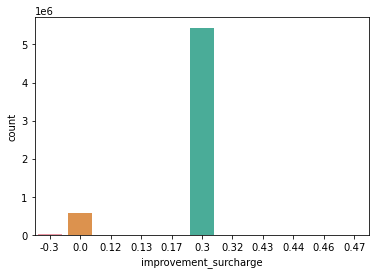

In [180]:
sns.countplot(df2019.improvement_surcharge)

In [49]:
df2019

VendorID lpep_pickup_datetime lpep_dropoff_datetime  \
0               2  2018-12-21 15:17:29   2018-12-21 15:18:57   
1               2  2019-01-01 00:10:16   2019-01-01 00:16:32   
2               2  2019-01-01 00:27:11   2019-01-01 00:31:38   
3               2  2019-01-01 00:46:20   2019-01-01 01:04:54   
4               2  2019-01-01 00:19:06   2019-01-01 00:39:43   
...           ...                  ...                   ...   
6044045         2  2019-12-31 23:26:00   2019-12-31 23:54:00   
6044046         2  2019-12-31 23:02:00   2019-12-31 23:16:00   
6044047         2  2019-12-31 23:24:00   2019-12-31 23:40:00   
6044048         2  2019-12-31 23:16:00   2019-12-31 23:37:00   
6044049         2  2019-12-31 23:52:00   2020-01-01 00:05:00   

        store_and_fwd_flag  RatecodeID  PULocationID  DOLocationID  \
0                        N           1           264           264   
1                        N           1            97            49   
2                        N           1            49           189   
3                        N           1           189            17   
4                        N           1            82           258   
...                    ...         ...           ...           ...   
6044045                  N           1            35           130   
6044046                  N           1            76            61   
6044047                  N           1           185           247   
6044048                  N           1            51           126   
6044049                  N           1            42           244   

         passenger_count  trip_distance  fare_amount  ...  tolls_amount  \
0                      5           0.00         3.00  ...           0.0   
1                      2           0.86         6.00  ...           0.0   
2                      2           0.66         4.50  ...           0.0   
3                      2           2.68        13.50  ...           0.0   
4                      1           4.53        18.00  ...           0.0   
...                  ...            ...          ...  ...           ...   
6044045                1          10.02        48.85  ...           0.0   
6044046                1           2.27        23.31  ...           0.0   
6044047                1           9.35        27.27  ...           0.0   
6044048                1          -7.16        35.95  ...           0.0   
6044049                1           2.43        21.15  ...           0.0   

         improvement_surcharge  total_amount  payment_type  trip_type  \
0                          0.3          4.30             2          1   
1                          0.3          7.30             2          1   
2                          0.3          5.80             1          1   
3                          0.3         19.71             1          1   
4                          0.3         19.30             2          1   
...                        ...           ...           ...        ...   
6044045                    0.3         51.90             1          1   
6044046                    0.3         26.36             1          1   
6044047                    0.3         30.32             1          1   
6044048                    0.3         39.50             1          1   
6044049                    0.0         24.40             1          1   

         trip_duration  year  month  day  hour  
0                 88.0  2018     12   21    15  
1                376.0  2019      1    1     0  
2                267.0  2019      1    1     0  
3               1114.0  2019      1    1     0  
4               1237.0  2019      1    1     0  
...                ...   ...    ...  ...   ...  
6044045         1680.0  2019     12   31    23  
6044046          840.0  2019     12   31    23  
6044047          960.0  2019     12   31    23  
6044048         1260.0  2019     12   31    23  
6044049          780.0  2019     12   31    23  

[6044050 rows x 23 columns]

In [50]:
# check dataframe dimensions
print(df2019.shape, df2018.shape, df2017.shape)

(6044050, 23) (8807303, 23) (11740667, 23)


In [21]:
# check dataframe info
df2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6044050 entries, 0 to 6044049
Data columns (total 18 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   VendorID               int64  
 1   lpep_pickup_datetime   object 
 2   lpep_dropoff_datetime  object 
 3   store_and_fwd_flag     object 
 4   RatecodeID             int64  
 5   PULocationID           int64  
 6   DOLocationID           int64  
 7   passenger_count        int64  
 8   trip_distance          float64
 9   fare_amount            float64
 10  extra                  float64
 11  mta_tax                float64
 12  tip_amount             float64
 13  tolls_amount           float64
 14  improvement_surcharge  float64
 15  total_amount           float64
 16  payment_type           int64  
 17  trip_type              int64  
dtypes: float64(8), int64(7), object(3)
memory usage: 830.0+ MB


In [23]:
# check for NaN again
df2019.isnull().any()

VendorID                 False
lpep_pickup_datetime     False
lpep_dropoff_datetime    False
store_and_fwd_flag       False
RatecodeID               False
PULocationID             False
DOLocationID             False
passenger_count          False
trip_distance            False
fare_amount              False
extra                    False
mta_tax                  False
tip_amount               False
tolls_amount             False
improvement_surcharge    False
total_amount             False
payment_type             False
trip_type                False
dtype: bool

In [48]:
# construct time related features
for df in [df2019, df2018, df2017]:
    df['trip_duration'] = (pd.to_datetime(df['lpep_dropoff_datetime']) - pd.to_datetime(
            df['lpep_pickup_datetime'])).dt.total_seconds()

    df['year'] = pd.DatetimeIndex(df['lpep_pickup_datetime']).year
    df['month'] = pd.DatetimeIndex(df['lpep_pickup_datetime']).month
    df['day'] = pd.DatetimeIndex(df['lpep_pickup_datetime']).day
    df['hour'] = pd.DatetimeIndex(df['lpep_pickup_datetime']).hour
    

In [16]:
# other features
df['average_speed'] = df['trip_distance'] / df['trip_duration'] * 3600

### 2.2 Exploratory Data Analysis

In [3]:
# create 3-year full data set
# df = pd.concat([pd.read_csv('greenTaxi2019.csv'), pd.read_csv('greenTaxi2018.csv'), pd.read_csv('greenTaxi2017.csv')])
df = pd.read_csv('greenTaxi2017-2019.csv')

In [18]:
df.to_csv('greenTaxi2017-2019.csv')

In [4]:
df = df.drop(columns = 'Unnamed: 0', axis = 1)

In [17]:
df.head(10)

VendorID lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag  \
0         2  2019-01-01 00:10:16   2019-01-01 00:16:32                  N   
1         2  2019-01-01 00:27:11   2019-01-01 00:31:38                  N   
2         2  2019-01-01 00:46:20   2019-01-01 01:04:54                  N   
3         2  2019-01-01 00:19:06   2019-01-01 00:39:43                  N   
4         2  2019-01-01 00:12:35   2019-01-01 00:19:09                  N   
5         2  2019-01-01 00:47:55   2019-01-01 01:00:01                  N   
6         1  2019-01-01 00:12:47   2019-01-01 00:30:50                  N   
7         2  2019-01-01 00:16:23   2019-01-01 00:39:46                  N   
8         2  2019-01-01 00:58:02   2019-01-01 01:19:02                  N   
9         2  2019-01-01 00:37:00   2019-01-01 00:56:42                  N   

   RatecodeID  PULocationID  DOLocationID  passenger_count  trip_distance  \
0           1            97            49                2           0.86   
1           1            49           189                2           0.66   
2           1           189            17                2           2.68   
3           1            82           258                1           4.53   
4           1            49            17                1           1.05   
5           1           255            33                1           3.77   
6           1            76           225                1           4.10   
7           1            25            89                1           7.75   
8           1            85            39                1           3.68   
9           1           223           238                1           6.84   

   fare_amount  ...  improvement_surcharge  total_amount  payment_type  \
0          6.0  ...                    0.3          7.30             2   
1          4.5  ...                    0.3          5.80             1   
2         13.5  ...                    0.3         19.71             1   
3         18.0  ...                    0.3         19.30             2   
4          6.5  ...                    0.3          7.80             1   
5         13.5  ...                    0.3         14.80             1   
6         16.0  ...                    0.3         17.30             1   
7         25.5  ...                    0.3         26.80             1   
8         15.5  ...                    0.3         16.80             1   
9         22.0  ...                    0.3         37.06             1   

   trip_type  trip_duration  year  month  day  hour  average_speed  
0        1.0          376.0  2019      1    1     0       8.234043  
1        1.0          267.0  2019      1    1     0       8.898876  
2        1.0         1114.0  2019      1    1     0       8.660682  
3        1.0         1237.0  2019      1    1     0      13.183508  
4        1.0          394.0  2019      1    1     0       9.593909  
5        1.0          726.0  2019      1    1     0      18.694215  
6        1.0         1083.0  2019      1    1     0      13.628809  
7        1.0         1403.0  2019      1    1     0      19.885959  
8        1.0         1260.0  2019      1    1     0      10.514286  
9        1.0         1182.0  2019      1    1     0      20.832487  

[10 rows x 24 columns]

In [22]:
df.describe()

VendorID    RatecodeID  PULocationID  DOLocationID  \
count  2.598802e+07  2.598802e+07  2.598802e+07  2.598802e+07   
mean   1.826399e+00  1.095076e+00  1.103741e+02  1.288727e+02   
std    3.787662e-01  6.026252e-01  7.422582e+01  7.685087e+01   
min    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
25%    2.000000e+00  1.000000e+00  4.900000e+01  6.200000e+01   
50%    2.000000e+00  1.000000e+00  8.200000e+01  1.290000e+02   
75%    2.000000e+00  1.000000e+00  1.660000e+02  1.930000e+02   
max    2.000000e+00  9.900000e+01  2.650000e+02  2.650000e+02   

       passenger_count  trip_distance   fare_amount         extra  \
count     2.598802e+07   2.598802e+07  2.598802e+07  2.598802e+07   
mean      1.343416e+00   3.040831e+00  1.292380e+01  3.890108e-01   
std       1.016062e+00   3.364600e+00  1.043050e+01  5.327454e-01   
min       0.000000e+00   1.000000e-02 -1.462000e+01 -7.200000e-01   
25%       1.000000e+00   1.070000e+00  6.500000e+00  0.000000e+00   
50%       1.000000e+00   1.890000e+00  9.500000e+00  5.000000e-01   
75%       1.000000e+00   3.640000e+00  1.550000e+01  5.000000e-01   
max       9.000000e+00   9.994000e+01  9.999900e+02  3.000000e+01   

            mta_tax    tip_amount  ...  improvement_surcharge  total_amount  \
count  2.598802e+07  2.598802e+07  ...           2.598802e+07  2.598802e+07   
mean   4.918372e-01  1.075129e+00  ...           2.892949e-01  1.543455e+01   
std    6.345502e-02  2.012693e+00  ...           5.565014e-02  1.173271e+01   
min   -5.000000e-01  0.000000e+00  ...           0.000000e+00  0.000000e+00   
25%    5.000000e-01  0.000000e+00  ...           3.000000e-01  8.300000e+00   
50%    5.000000e-01  0.000000e+00  ...           3.000000e-01  1.176000e+01   
75%    5.000000e-01  1.820000e+00  ...           3.000000e-01  1.835000e+01   
max    3.800000e+00  4.500000e+02  ...           3.000000e-01  9.999900e+02   

       payment_type     trip_type  trip_duration          year         month  \
count  2.598802e+07  2.598802e+07   2.598802e+07  2.598802e+07  2.598802e+07   
mean   1.457340e+00  1.023147e+00   8.533571e+02  2.017782e+03  6.208184e+00   
std    5.130230e-01  1.503714e-01   7.226641e+02  7.875214e-01  3.462224e+00   
min    1.000000e+00  1.000000e+00   1.000000e+00  2.017000e+03  1.000000e+00   
25%    1.000000e+00  1.000000e+00   3.850000e+02  2.017000e+03  3.000000e+00   
50%    1.000000e+00  1.000000e+00   6.440000e+02  2.018000e+03  6.000000e+00   
75%    2.000000e+00  1.000000e+00   1.078000e+03  2.018000e+03  9.000000e+00   
max    5.000000e+00  2.000000e+00   9.999000e+03  2.019000e+03  1.200000e+01   

                day          hour  average_speed  
count  2.598802e+07  2.598802e+07   2.598802e+07  
mean   1.558964e+01  1.378600e+01   1.419227e+01  
std    8.767961e+00  6.151394e+00   1.260497e+02  
min    1.000000e+00  0.000000e+00   3.671222e-03  
25%    8.000000e+00  1.000000e+01   8.780488e+00  
50%    1.600000e+01  1.500000e+01   1.105566e+01  
75%    2.300000e+01  1.900000e+01   1.421755e+01  
max    3.100000e+01  2.300000e+01   1.211400e+05  

[8 rows x 21 columns]

In [7]:
# filter out invalid data entries and outliers
df = df[(df.trip_distance > 0) 
        & (df.trip_distance < 100) 
        & (df.trip_duration > 0) 
        & (df.trip_duration < 79200) 
        & (df.total_amount >= 0) 
        & (df.total_amount < 1000) 
        & (df.year >= 2017) 
        & (df.year <= 2019)
        & (df.average_speed <= 100)]

In [5]:
len(df)

25947818

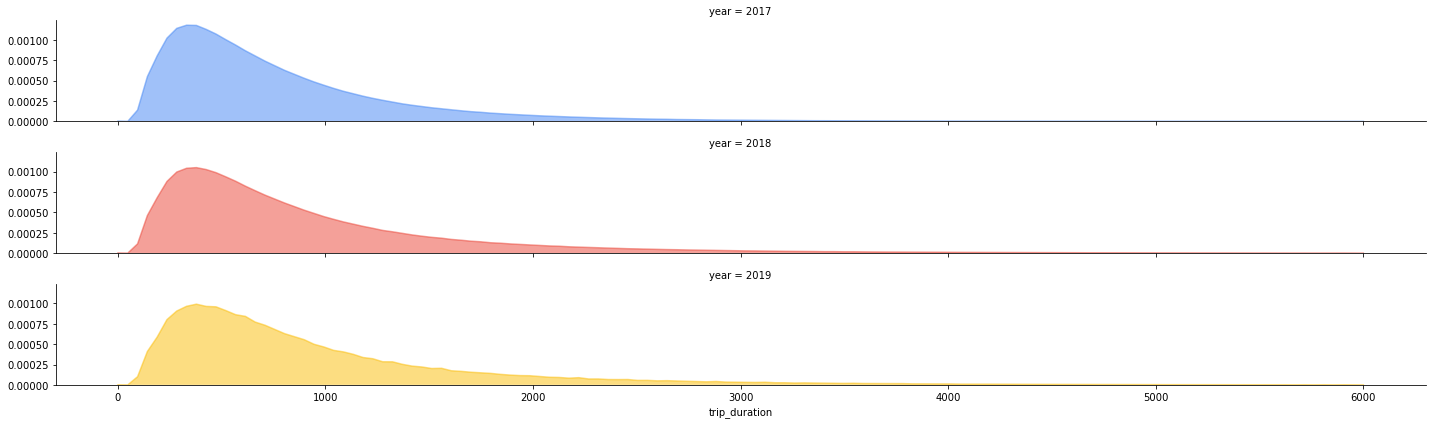

In [6]:
# compare trip_duration distribution across 3 years
temp = df[(df.trip_duration < 6000)]

g = sns.FacetGrid(temp, #the dataframe to pull from
                  row="year", #define the column for each subplot row to be differentiated by
                  hue="year", #define the column for each subplot color to be differentiated by
                  aspect=10, #aspect * height = width
                  height=2, #height of each subplot
                  palette=['#4285F4','#EA4335','#FBBC05'] #google colors
                 )

g.map(sns.kdeplot, "trip_duration", shade=True, alpha=0.5, lw=1.5, bw=0.2)

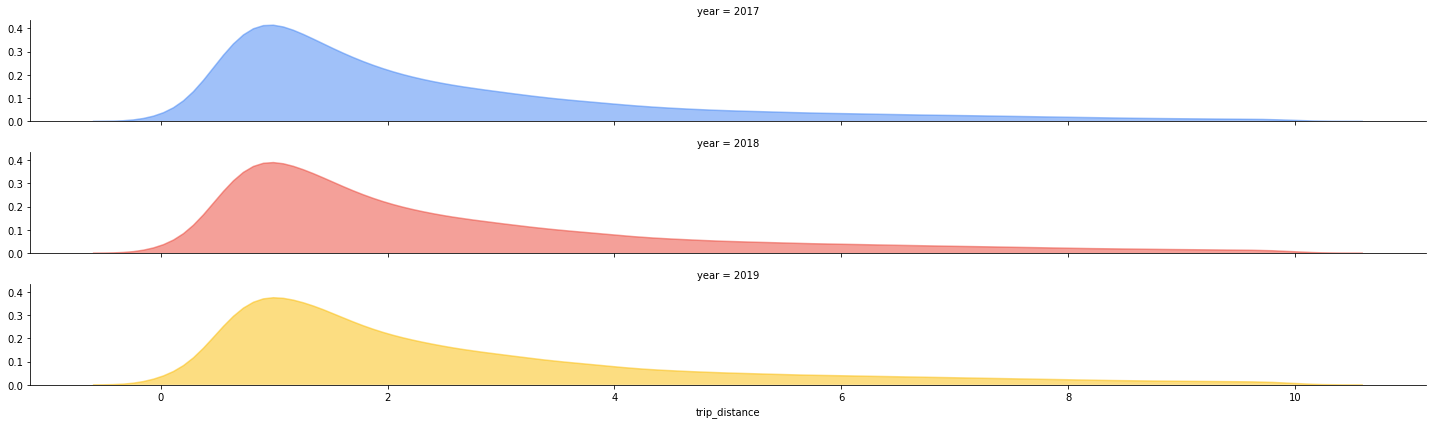

In [19]:
# compare trip_distance distribution across 3 years
temp = df[(df.trip_distance < 10)]

g = sns.FacetGrid(temp, #the dataframe to pull from
                  row="year", #define the column for each subplot row to be differentiated by
                  hue="year", #define the column for each subplot color to be differentiated by
                  aspect=10, #aspect * height = width
                  height=2, #height of each subplot
                  palette=['#4285F4','#EA4335','#FBBC05'] #google colors
                 )

g.map(sns.kdeplot, "trip_distance", shade=True, alpha=0.5, lw=1.5, bw=0.2)

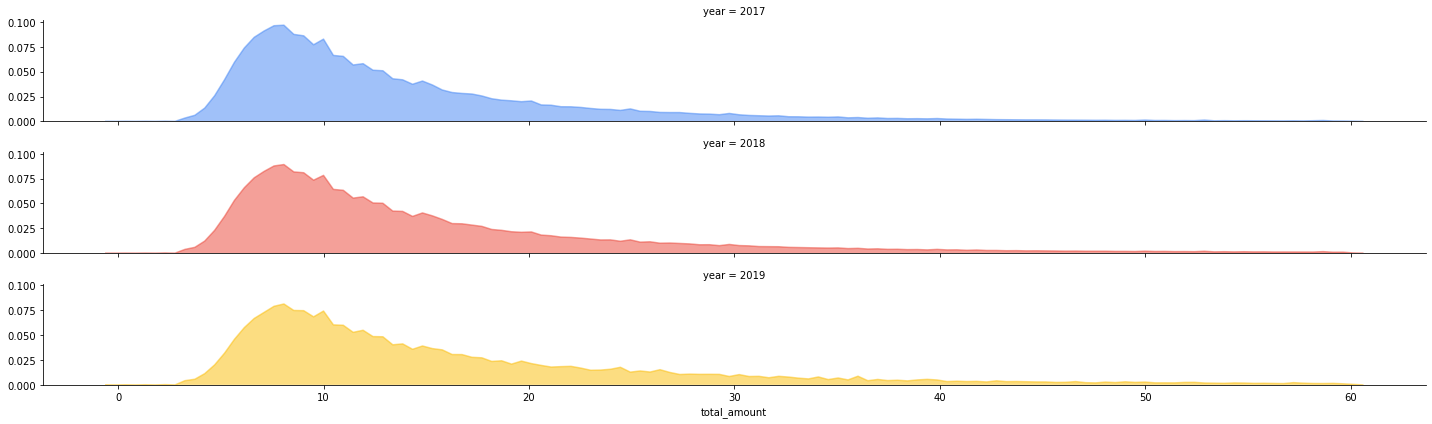

In [6]:
# compare total_amount distribution across 3 years
temp = df[(df.total_amount < 60)]

g = sns.FacetGrid(temp, #the dataframe to pull from
                  row="year", #define the column for each subplot row to be differentiated by
                  hue="year", #define the column for each subplot color to be differentiated by
                  aspect=10, #aspect * height = width
                  height=2, #height of each subplot
                  palette=['#4285F4','#EA4335','#FBBC05'] #google colors
                 )

g.map(sns.kdeplot, "total_amount", shade=True, alpha=0.5, lw=1.5, bw=0.2)

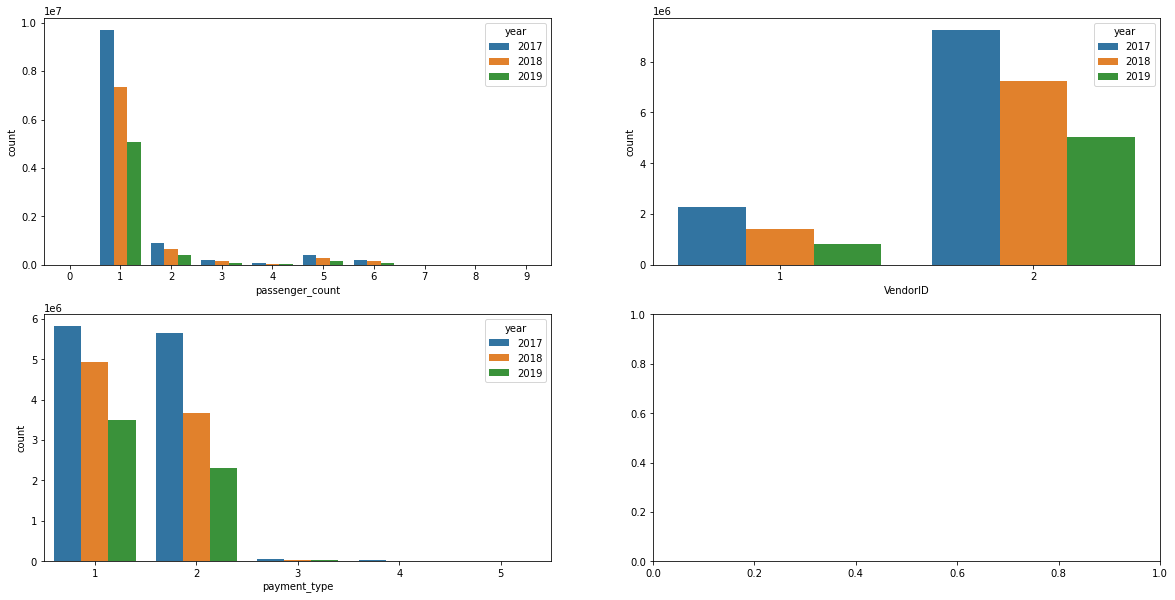

In [13]:
# compare over other features
_,axss = plt.subplots(2,2, figsize=[20,10])

sns.countplot(x="passenger_count", hue="year", data=df, ax=axss[0][0])
sns.countplot(x="VendorID", hue="year", data=df, ax=axss[0][1])
sns.countplot(x="payment_type", hue="year", data=df, ax=axss[1][0])

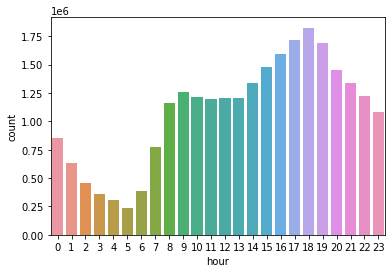

In [9]:
# plot trips over hour
g = sns.countplot(x="hour", data=df)

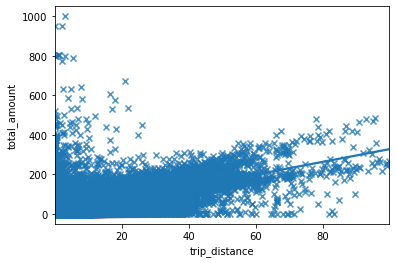

In [11]:
# plot fare over distance
g = sns.regplot(x="trip_distance", y = "total_amount", data=df, marker = "x")

[(0.0, 60.0)]

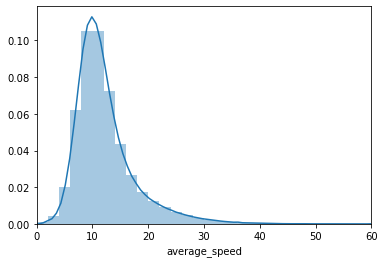

In [8]:
# plot trip average speed
g = sns.distplot(df.average_speed)
g.set(xlim=(0, 60))

In [38]:
temp = df.groupby(['month','day'])['average_speed'].mean()
temp

month  day
1      1      14.527030
       2      13.166084
       3      12.133455
       4      12.390000
       5      12.046847
                ...    
12     27     12.789587
       28     12.636131
       29     12.762691
       30     13.066962
       31     12.935218
Name: average_speed, Length: 365, dtype: float64

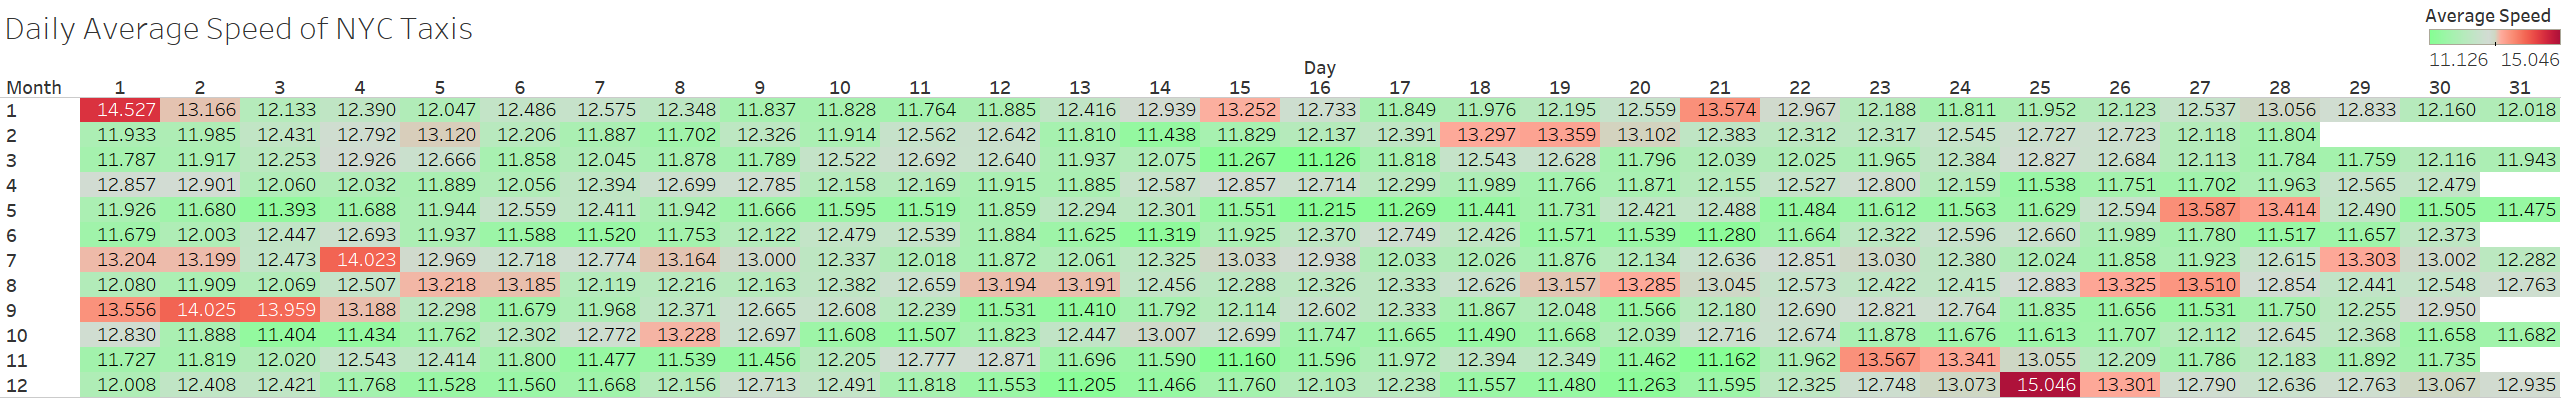

In [44]:
Image.open('speed.png')

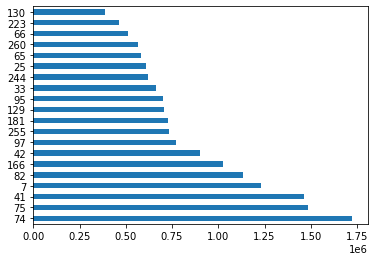

In [9]:
# most popular pick up locations
df['PULocationID'].value_counts().head(20).plot(kind='barh')

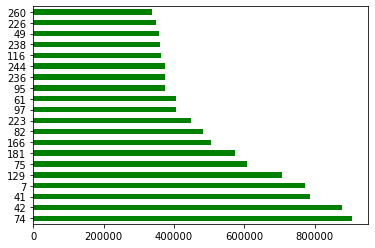

In [10]:
# most popular drop off locations
df['DOLocationID'].value_counts().head(20).plot(kind='barh', color = 'g')

### 2.4 Goal Metric Setup

For this part, we also need to determine a way to define rides that are 'near a hospital'. Since in the dataset, we have district codes instead of exact coordinate (latitude and longitude), we classify rides as possibly going for hospital, if the drop off location is in the same area as a local hospital. 

On google maps, hospitals in NYC are located by the following way:

1. Identify RED areas indicating medical buildings on the map, like in the following picture.
2. Manually search for other major hospitals.

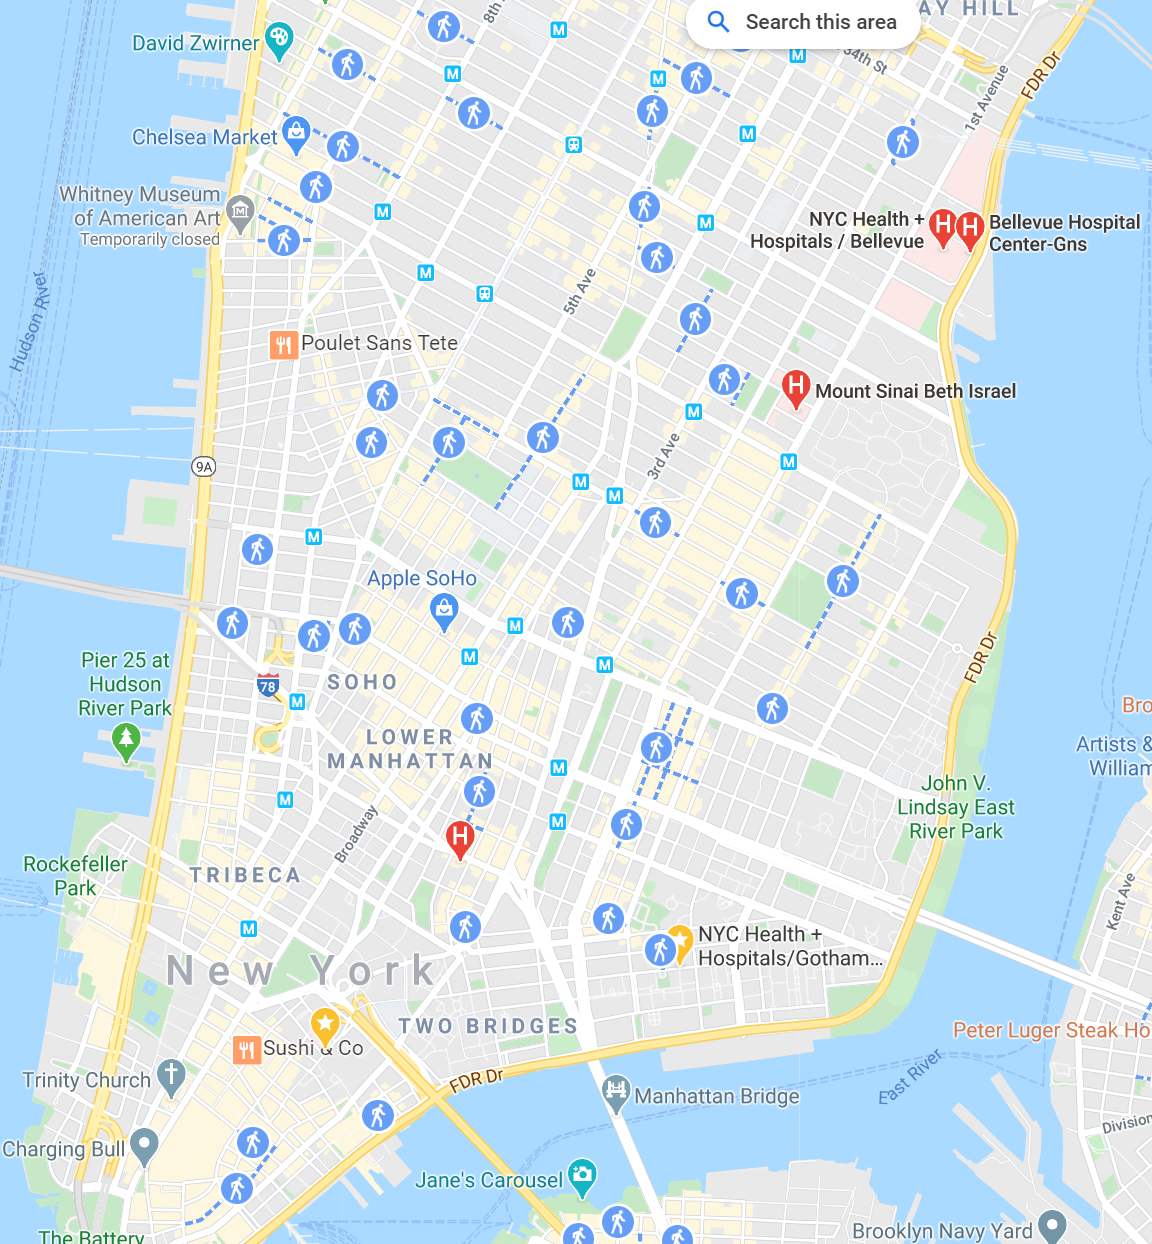

In [4]:
Image.open('hospital1.png')

In [5]:
# import the dataset containing the binary target feature
zones = pd.read_csv('taxi_zone_lookup.csv')
zones.head()

LocationID Borough                     Zone service_zone  Hospital
0           3   Bronx  Allerton/Pelham Gardens    Boro Zone         0
1          18   Bronx             Bedford Park    Boro Zone         0
2          20   Bronx                  Belmont    Boro Zone         0
3          31   Bronx               Bronx Park    Boro Zone         0
4          32   Bronx                Bronxdale    Boro Zone         1

In [6]:
sum(zones.Hospital)

50

In [7]:
# Out of 265 zones there are 50 zones with hospitals
valid_zone = list(zones[zones.Hospital == 1].LocationID)

Area code requires much less work but doesn't label as accurately as coordinates, and many other rides would be counted in as 'hospital rides'. Hence it is a vauge method, and we might want to exclude some generally famous places to increase our accuracy, because it is more likely for a customer to be heading for other matters than going to a hospital, if he/she lands in the mostly visited areas.

In [8]:
ignore = list(df['PULocationID'].value_counts().head(20).keys())

for id in ignore:
    if id in valid_zone:
        valid_zone.remove(id)

In [10]:
def in_zone(DOLocationID):
    res = []
    for i in DOLocationID:
        if i in valid_zone:
            res.append(1)
        else:
            res.append(0)
    return res
    
df['hospital_zone'] = in_zone(df['DOLocationID'])

In [14]:
# about 15% of valid trips ended near a hospital
sum(df.hospital_zone)/len(df)

0.1537164319558585

In [15]:
temp = df.groupby(['year','month'])['hospital_zone'].sum() / df.groupby(['year','month'])['hospital_zone'].count()
temp

year  month
2017  1        0.151058
      2        0.151230
      3        0.147884
      4        0.150025
      5        0.147232
      6        0.147373
      7        0.145485
      8        0.146996
      9        0.149921
      10       0.150105
      11       0.151176
      12       0.149367
2018  1        0.152688
      2        0.154513
      3        0.153133
      4        0.155003
      5        0.155361
      6        0.155606
      7        0.153597
      8        0.153345
      9        0.157800
      10       0.160939
      11       0.158954
      12       0.158279
2019  1        0.164824
      2        0.163027
      3        0.160227
      4        0.158369
      5        0.155711
      6        0.154674
      7        0.158566
      8        0.157651
      9        0.162583
      10       0.164326
      11       0.160139
      12       0.159726
Name: hospital_zone, dtype: float64

In [16]:
temp.to_csv('temp_2019.csv')

We have generated the desired data from 2017 to 2019, and now we can start the next part.